In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
import data_processing 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.inspection import permutation_importance
import importlib
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
import models
importlib.reload(data_processing)
import pickle

<module 'data_processing' from '/home/robin/uu/hcml/HCML_Project/data_processing.py'>

In [85]:
x_train, x_test, y_train, y_test = data_processing.data_selected_features()

In [86]:
### SHAP
def get_shap_values(model, x_train, x_test):
    explainer = shap.KernelExplainer(model.predict,x_train)
    shap_values = explainer.shap_values(x_test)
    return shap_values


In [87]:
def get_random_feature(x_train, x_test, distributions, split_column= None, scaling = 0.01):
    if split_column ==  "":
        return  distributions[0], distributions[1]
    else:
        return x_train.copy()[split_column] + distributions[0] * scaling, x_test.copy()[split_column] + distributions[1] * scaling

        

In [106]:

# beta 
normal = (np.random.normal(0,1,  size=x_train.shape[0]), np.random.normal(0,1,  size=x_test.shape[0]))
weibull = (np.random.weibull(1.5,  size=x_train.shape[0]),np.random.weibull(1.5,  size=x_test.shape[0]))


distributions = [normal, weibull]
distributions_names = ["Normaldistribution", "Weibulldistribution"]
sharp_results = {}
sharp_results_unnormal = {}
ebm_results = {}
ebm_results_unnormal = {}
pfi_results = {}
pfi_results_unnormal = {}
split_column = ["", "Minimum Orbit Intersection", "Absolute Magnitude"]

for split in split_column:
    
    for names, dis in zip(distributions_names, distributions):
        x_train["Random"] , x_test["Random"] = get_random_feature(x_train, x_test, dis, split_column=split)

        nn = models.nn_model()
        nn.fit(x_train, y_train)
        s = get_shap_values(nn, x_train, x_test.iloc[0:2]).mean(axis=0)
        sharp_results_unnormal[f"{names}{split}"] = s
        shap_values = data_processing.normalize_data(abs(s))    
        sharp_results[f"{names}{split}"] = shap_values
        pfi_results[f"{names}{split}"] = data_processing.normalize_data(permutation_importance(nn, x_test, y_test, n_repeats=10)["importances_mean"])
        
        pfi_results_unnormal[f"{names}{split}"] = permutation_importance(nn, x_test, y_test, n_repeats=10)["importances_mean"]
        ebm = ExplainableBoostingClassifier().fit(x_train, y_train)
        ebm_values = data_processing.normalize_data(ebm.term_importances()[0:len(x_train.columns)])
        ebm_results_unnormal[f"{names}{split}"] = ebm.term_importances()[0:len(x_train.columns)]
        ebm_results[f"{names}{split}"] = ebm_values

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

Using 3749 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/2 [00:00<?, ?it/s]

In [100]:
def plot_bar(shap_values, ebm_values, pfi_values, columns, header="test"):
    #fig, ax = plt.subplots()
    df = pd.DataFrame({"feature" : columns, "EBM": ebm_values,"NN (SHARP)": shap_values , "NN (PFI)" : pfi_values} )
    df.sort_values(by=["NN (SHARP)"], inplace = True)
    
    df.plot.barh(x = 'feature', y = ['EBM', 'NN (SHARP)', "NN (PFI)"], color={"EBM": "#FFCD00", "NN (SHARP)": "#AA1555", "NN (PFI)": "#24A793"})
    plt.xlabel("Feature Importance")
    plt.legend(loc='right')
    #ax.legend("EBM": "Feature Importance EBM","NN": "Feature Importance NN"}
    plt.show()
    

In [90]:
def plot_distribution(distributions, header):
    
    # plot beta distribution
    plt.hist(distributions, bins=100, color="#C00A35")
    plt.title(header)
    
    plt.show()
    


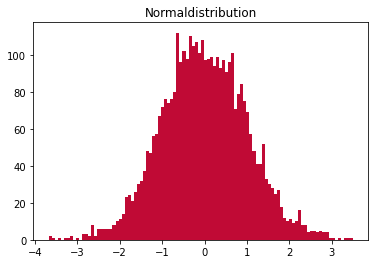

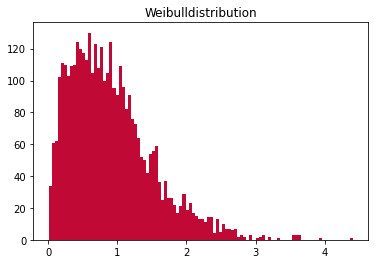

In [107]:
for name, dist in zip(distributions_names, distributions):
    plot_distribution(dist[0], name)

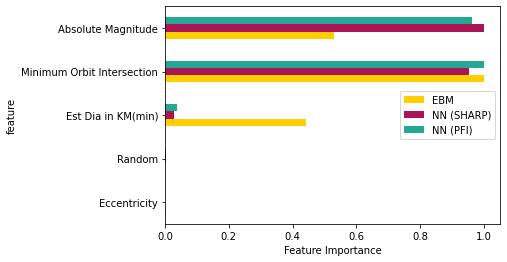

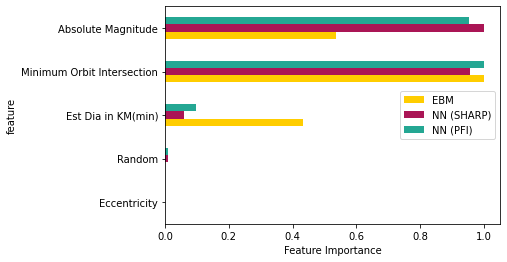

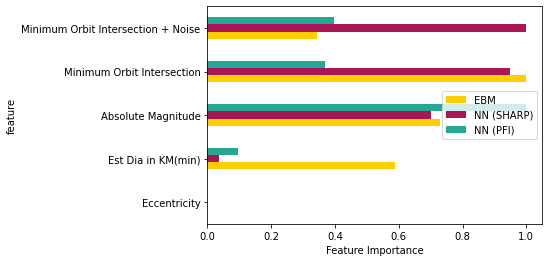

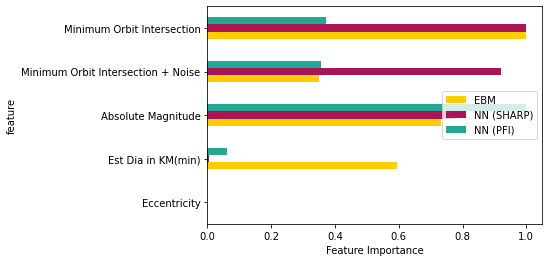

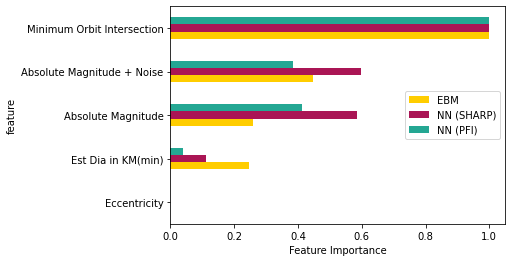

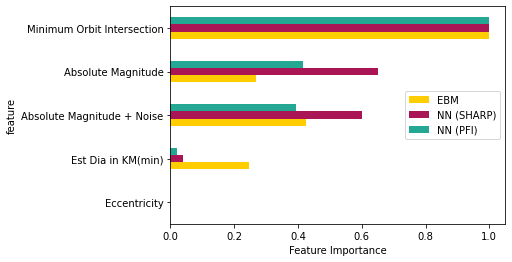

In [108]:

#fig, axs = plt.subplots(2,4)

for split in split_column:
    for dist in distributions_names:
        if split == "":
            plot_bar(sharp_results[f"{dist}{split}"], ebm_results[f"{dist}{split}"], pfi_results[f"{dist}{split}"],  x_train.columns, f"{dist}{split}")
        else:
            c = list(x_train.columns)
            i = c.index('Random')
            
            columns = c[:i] + [f"{split} + Noise"] +c[i+1:]
            plot_bar(sharp_results[f"{dist}{split}"], ebm_results[f"{dist}{split}"], pfi_results[f"{dist}{split}"],  columns, f"{dist}{split}")
